### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.datasets import fetch_openml
from scipy.stats import f
import researchpy as rp 
from scipy import stats
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

np.random.seed(1234)
import warnings

from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

warnings.filterwarnings("ignore")


In [47]:
from sklearn.datasets import fetch_openml

# Fetch the dataset
wages = fetch_openml(data_id=534, as_frame=True)

# Create a DataFrame from the fetched data
df = pd.concat([wages.data, wages.target], axis=1)

# Display the first few rows of the DataFrame
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,WAGE
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married,5.10
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married,4.95
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried,6.67
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried,4.00
4,12,no,male,17,not_member,35,White,Other,Other,Married,7.50


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
 10  WAGE        534 non-null    float64 
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


In [49]:
df.shape

(534, 11)

In [50]:
df.columns

Index(['EDUCATION', 'SOUTH', 'SEX', 'EXPERIENCE', 'UNION', 'AGE', 'RACE',
       'OCCUPATION', 'SECTOR', 'MARR', 'WAGE'],
      dtype='object')

In [51]:
# Using OneHotEncoder encoder

# cat_cols  -  list of categorical column names
cat_cols = ['SOUTH','SEX','UNION','RACE','OCCUPATION', 'SECTOR', 'MARR']

# Extract categorical variables into a separate DataFrame
cat_df = df[cat_cols]

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the categorical variables
cat_encoded = encoder.fit_transform(cat_df)

# Convert the encoded matrix to a DataFrame
cat_encoded_df = pd.DataFrame(cat_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, cat_encoded_df], axis=1)

# Drop the original categorical variables if needed
df_encoded.drop(cat_cols, axis=1, inplace=True)


In [52]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EDUCATION                534 non-null    int64  
 1   EXPERIENCE               534 non-null    int64  
 2   AGE                      534 non-null    int64  
 3   WAGE                     534 non-null    float64
 4   SOUTH_no                 534 non-null    float64
 5   SOUTH_yes                534 non-null    float64
 6   SEX_female               534 non-null    float64
 7   SEX_male                 534 non-null    float64
 8   UNION_member             534 non-null    float64
 9   UNION_not_member         534 non-null    float64
 10  RACE_Hispanic            534 non-null    float64
 11  RACE_Other               534 non-null    float64
 12  RACE_White               534 non-null    float64
 13  OCCUPATION_Clerical      534 non-null    float64
 14  OCCUPATION_Management    5

In [53]:
# Using label encoder to convert categorical to int format for model training and create dummies for final model
# cat_var = ['SOUTH','SEX','UNION','RACE','OCCUPATION', 'SECTOR', 'MARR']

# Initialize LabelEncoder
# label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
# for col in cat_var:
#     df[col] = label_encoder.fit_transform(df[col])

# Display the updated DataFrame
# df

#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

In [55]:
# EXPLORE THE DATA
df = df_encoded

In [56]:
# Identify and drop any duplicated records
duplicates = df[df.duplicated()]
df.drop_duplicates(inplace=True)
df.shape

(534, 24)

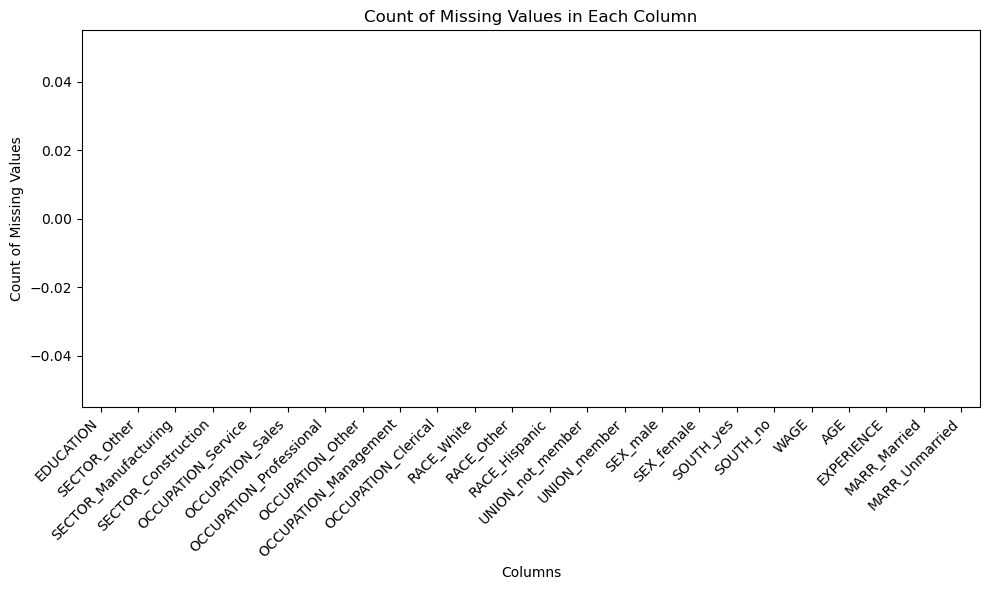

In [57]:
# Check misingness rates 
missing_values_count = df.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Count of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot (optional)
plt.show()

In [58]:
columns_with_nan = df.columns[df.isnull().sum() > 0]

# Print the columns containing NaN values
print(columns_with_nan)

Index([], dtype='object')


In [59]:
# Define continuous variables to summarize
continuous_vars = ['WAGE', 'EXPERIENCE','AGE']

# Function to compute summary statistics for a given column
def compute_summary_stats(df, column_name):
    summary_stats = {
        'mean': df[column_name].mean(),
        'std_dev': df[column_name].std(),
        'median': df[column_name].median(),
        'p1': df[column_name].quantile(0.01),
        'q1': np.percentile(df[column_name], 25),
        'q3': np.percentile(df[column_name], 75),
        'p95': df[column_name].quantile(0.95),
        'p99': df[column_name].quantile(0.99),
        'min': df[column_name].min(),
        'max': df[column_name].max()
    }
    return summary_stats

# Loop over each variable, compute summary stats, and print
for var in continuous_vars:
    summary_stats = compute_summary_stats(df, var)
    summary_df = pd.DataFrame(summary_stats, index=[var])
   # print(f"Summary statistics for {var}:")
    print(summary_df)
    print()

          mean   std_dev  median      p1    q1     q3    p95    p99  min   max
WAGE  9.024064  5.139097    7.78  3.1155  5.25  11.25  19.98  24.98  1.0  44.5

                 mean   std_dev  median   p1   q1    q3   p95    p99  min  max
EXPERIENCE  17.822097  12.37971    15.0  0.0  8.0  26.0  42.0  46.67    0   55

          mean    std_dev  median    p1    q1    q3   p95    p99  min  max
AGE  36.833333  11.726573    35.0  19.0  28.0  44.0  60.0  63.67   18   64



In [60]:
# Drop extreme outlying records
# df = df[(df['WAGE'] >= 3) & (df['WAGE'] <= 25)]
# df.shape

Shapiro-Wilk Test - Test Statistic: 0.867297351360321, p-value: 6.938121175043436e-21


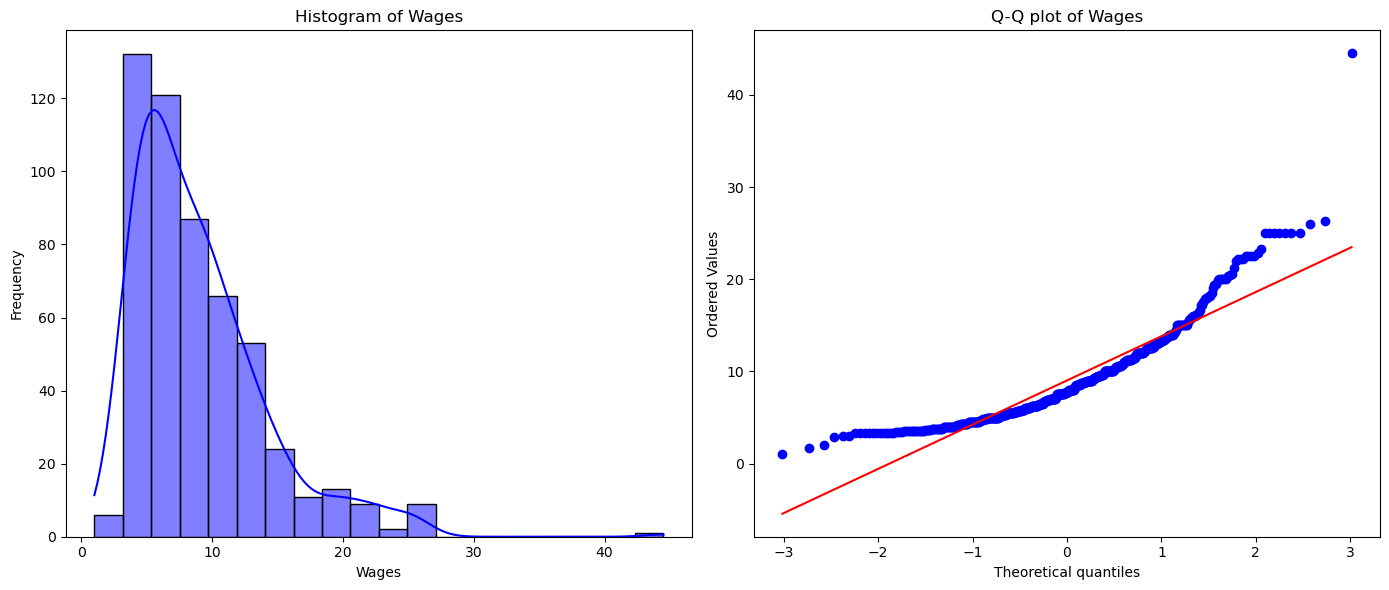

In [61]:
# TEST OF NORMALITY USING RESIDUALS
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Extract the y variable
y = df["WAGE"]

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of y variable
sns.histplot(y, kde=True, color='blue', bins=20, ax=ax1)
ax1.set_title('Histogram of Wages')
ax1.set_xlabel('Wages')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(y, dist="norm", plot=ax2)
ax2.set_title('Q-Q plot of Wages')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [62]:
df.columns

Index(['EDUCATION', 'EXPERIENCE', 'AGE', 'WAGE', 'SOUTH_no', 'SOUTH_yes',
       'SEX_female', 'SEX_male', 'UNION_member', 'UNION_not_member',
       'RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other', 'OCCUPATION_Professional',
       'OCCUPATION_Sales', 'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR_Married',
       'MARR_Unmarried'],
      dtype='object')

In [63]:
# BEST TRANSFORMATION METHOD

X = df[['EDUCATION', 'EXPERIENCE', 'AGE', 'SOUTH_no', 'SOUTH_yes',
       'SEX_female', 'SEX_male', 'UNION_member', 'UNION_not_member',
       'RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other', 'OCCUPATION_Professional',
       'OCCUPATION_Sales', 'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR_Married',
       'MARR_Unmarried']]
y = df['WAGE']

# Define different transformations
transformations = ['log', 'sqrt', 'boxcox', 'reciprocal']

best_score = -np.inf
best_transformation = None
best_model = None

for transformation in transformations:
    # Apply transformation to the target variable
    if transformation == 'log':
        y_transformed = np.log(y)
    elif transformation == 'sqrt':
        y_transformed = np.sqrt(y)
    elif transformation == 'boxcox':
        y_transformed, _ = stats.boxcox(y)
    elif transformation == 'reciprocal':
        y_transformed = 1 / y
#    elif transformation == 'exp':
 #       y_transformed = np.exp(y)
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y_transformed)
    
    # Evaluate model performance
    y_pred_transformed = model.predict(X)
    score = r2_score(y_transformed, y_pred_transformed)
    
    # Update best transformation if necessary
    if score > best_score:
        best_score = score
        best_transformation = transformation
        best_model = model

print("Best transformation:", best_transformation)
print("Best R-squared score:", best_score)


Best transformation: log
Best R-squared score: 0.3617450058488284


In [64]:
df["WAGE_log"] = np.log(df['WAGE'])
df

,EDUCATION,EXPERIENCE,AGE,WAGE,SOUTH_no,SOUTH_yes,SEX_female,SEX_male,UNION_member,UNION_not_member,...,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Married,MARR_Unmarried,WAGE_log
0,8,21,35,5.10,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.629241
1,9,42,57,4.95,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.599388
2,12,1,19,6.67,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.897620
3,12,4,22,4.00,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.386294
4,12,17,35,7.50,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.014903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,18,5,29,11.36,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.430098
530,12,33,51,6.10,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.808289
531,17,25,48,23.25,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.146305
532,12,13,31,19.88,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.989714


Shapiro-Wilk Test - Test Statistic: 0.9890875220298767, p-value: 0.0005222364561632276


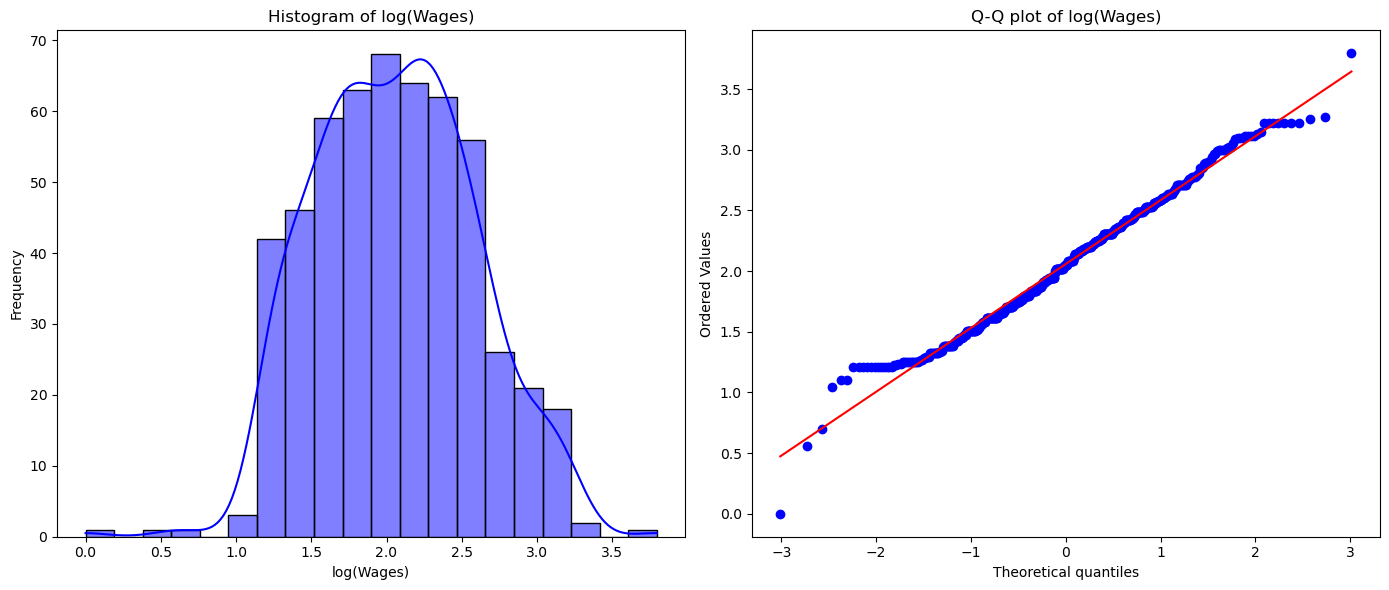

In [65]:
# TEST OF NORMALITY USING RESIDUALS
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Extract the y variable
y = df["WAGE_log"]

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of y variable
sns.histplot(y, kde=True, color='blue', bins=20, ax=ax1)
ax1.set_title('Histogram of log(Wages)')
ax1.set_xlabel('log(Wages)')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(y, dist="norm", plot=ax2)
ax2.set_title('Q-Q plot of log(Wages)')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


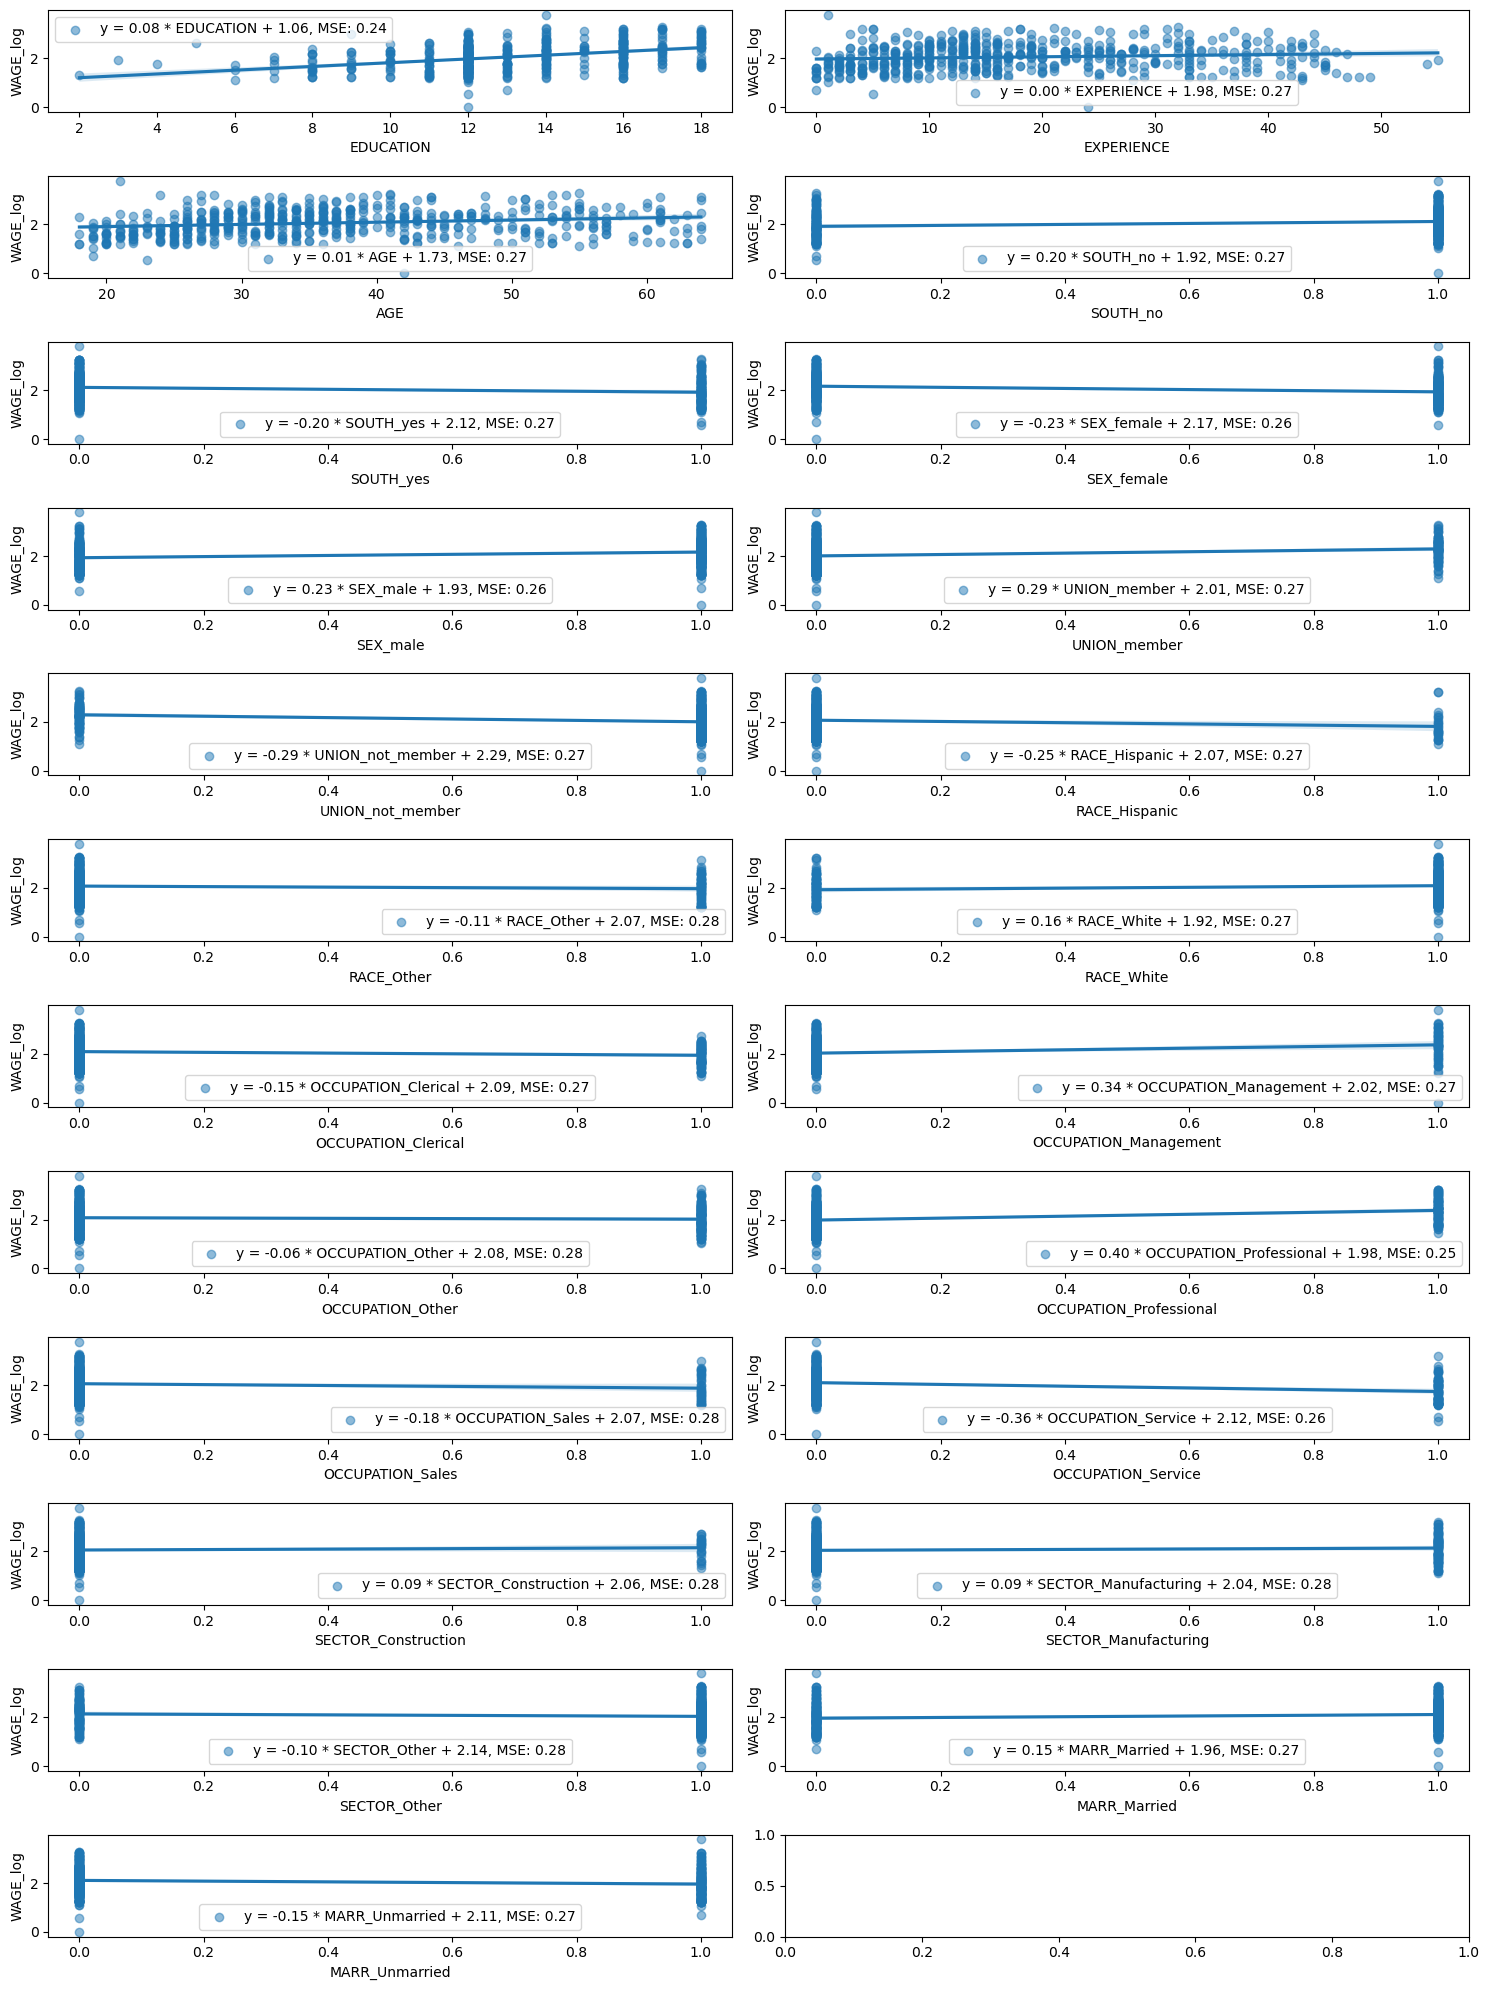

In [66]:
# Bivariate modeling & visualizations

# Define predictors (X) and target variable (y)

X = df[['EDUCATION', 'EXPERIENCE', 'AGE', 'SOUTH_no', 'SOUTH_yes',
       'SEX_female', 'SEX_male', 'UNION_member', 'UNION_not_member',
       'RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other', 'OCCUPATION_Professional',
       'OCCUPATION_Sales', 'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR_Married',
       'MARR_Unmarried']]
y = df['WAGE_log']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Create subplots for each predictor
fig, axes = plt.subplots(12, 2, figsize=(15, 20))
axes = axes.flatten()

# Plot each predictor against y with regression line
for i, predictor in enumerate(X.columns):
    sns.regplot(x=predictor, y=y, data=df, ax=axes[i], scatter_kws={'alpha':0.5})
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_imputed[:, i].reshape(-1, 1), y)
    
    # Make predictions
    predictions = model.predict(X_imputed[:, i].reshape(-1, 1))
    
    # Calculate and display Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    
    # Get slope (m) and intercept (b) of the regression line
    m = model.coef_[0]
    b = model.intercept_
    
    # Add equation to legend
    equation = f'y = {m:.2f} * {predictor} + {b:.2f}, MSE: {mse:.2f}'
    axes[i].legend([equation])

plt.tight_layout()
plt.show()


In [67]:
# Split data into training and testing sets
X = df.drop(columns=['WAGE','WAGE_log'])
y = df['WAGE_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(427, 23) (107, 23) (427,) (107,)


In [68]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [69]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
RACE_Hispanic,inf
RACE_Other,inf
UNION_member,inf
SOUTH_yes,inf
SOUTH_no,inf
SEX_male,inf
SEX_female,inf
SECTOR_Other,inf
SECTOR_Manufacturing,inf
SECTOR_Construction,inf


In [82]:
# Features with VIF>10 not dropped since we are using Ridge regression


In [70]:
# Detemine best Alpha for Ridge regression regularization 

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('ridge', Ridge())  # Ridge Regression model
])

# Set up the parameter grid
param_grid = {
    'ridge__alpha': 10**np.linspace(-5, 4, 100) 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV to find the best model
grid_search.fit(X_train, y_train)

# Print the best alpha and best score found by GridSearchCV
print("Best alpha:", grid_search.best_params_['ridge__alpha'])
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 65.79332246575683
Best CV score: -0.18885267970941388


In [71]:
# Permutatin importance

#Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Ridge Regression model
ridge = Ridge(alpha=65.79)  
ridge.fit(X_train_scaled, y_train)

# Compute permutation importance
perm_importance = permutation_importance(ridge, X_test_scaled, y_test, random_state=42)

# Create a DataFrame for permutation importance results
perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance['importances_mean'],
    'importance_std': perm_importance['importances_std']
})

# Sort by mean importance for visualization
perm_importance_df = perm_importance_df.sort_values(by='importance_mean', ascending=False)

# Print or visualize the permutation importance results
print("Permutation Importance:")
print(perm_importance_df)

Permutation Importance:
                    feature  importance_mean  importance_std
0                 EDUCATION         0.203168        0.037115
15  OCCUPATION_Professional         0.053848        0.012644
13    OCCUPATION_Management         0.042649        0.008747
17       OCCUPATION_Service         0.036241        0.019059
5                SEX_female         0.026668        0.015172
6                  SEX_male         0.026668        0.015172
2                       AGE         0.021567        0.019482
14         OCCUPATION_Other         0.013670        0.004482
16         OCCUPATION_Sales         0.013595        0.006493
4                 SOUTH_yes         0.006162        0.004764
3                  SOUTH_no         0.006162        0.004764
11               RACE_White         0.004118        0.002656
9             RACE_Hispanic         0.003817        0.002804
10               RACE_Other         0.001071        0.000885
12      OCCUPATION_Clerical         0.000296        0.000118


In [ ]:
# Not dropping features with negative importance mean since Rigde regression should shrink these to zero

In [92]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression

# Split data into features (X) and target (y)
X = df.drop(columns=['WAGE', 'WAGE_log'])
y = df['WAGE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Define a transformer for the target variable (logarithmic transformation)
transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# Initialize a StandardScaler for scaling features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize TransformedTargetRegressor with Ridge Regression as the base estimator
alpha = 65.79
ridge = Ridge(alpha=alpha)  # Ridge regression with specified alpha
tt_reg = TransformedTargetRegressor(regressor=ridge, transformer=transformer)

# Fit the TransformedTargetRegressor on the training data
tt_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = tt_reg.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {ridge_mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Get parameter estimates (coefficients)
coefficients_log = tt_reg.regressor_.coef_
intercept_log = tt_reg.regressor_.intercept_

# Inverse transform to interpret in original scale
coefficients = np.expm1(coefficients_log)
intercept = np.expm1(intercept_log)

# F-test and p-values (assuming all features are used)
f_test, p_values = f_regression(X_test_scaled, y_test)

# Create DataFrame to store results
results_df = pd.DataFrame({
    'Parameter': X.columns,
    'Coefficient': coefficients,
    'P-value': p_values
})

# Filter significant parameters (p-value <= 0.05)
significant_results = results_df[results_df['P-value'] <= 0.05]

# Display significant parameter estimates with p-values
print("\nSignificant Parameters with P-values <= 0.05:")
for index, row in significant_results.iterrows():
    print(f"{row['Parameter']}: Coefficient={row['Coefficient']}, P-value={row['P-value']}")

# Perform F-test for the whole model
f_statistic, f_test_p_value = f_test.mean(), f_regression(X_test_scaled, y_test)[1].mean()

# Display F-test statistic and p-value for the whole model
print(f"\nF-test for the Model: F-test={f_statistic}, p-value={f_test_p_value}")

# Output model equation for significant parameters
print("\nModel Equation for Significant Parameters:")
equation_parts = []
for index, row in significant_results.iterrows():
    coef = row['Coefficient']
    param_name = row['Parameter']
    if coef >= 0:
        equation_parts.append(f" + ({coef:.3f} * {param_name})")
    else:
        equation_parts.append(f" - ({-coef:.3f} * {param_name})")
model_equation = f"WAGE = {intercept:.3f}" + "".join(equation_parts)
print(model_equation)

ridge_r_squared = r2
ridge_f_value = f_statistic
ridge_pval = f_test_p_value

(427, 23) (107, 23) (427,) (107,)
MSE: 21.892670999554635
R-squared: 0.31324677623391506

Significant Parameters with P-values <= 0.05:
EDUCATION: Coefficient=0.10096814998609079, P-value=3.324570362411413e-10
SOUTH_no: Coefficient=0.014816429223958528, P-value=0.026043929449186577
SOUTH_yes: Coefficient=-0.01460010776066053, P-value=0.026043929449186577
SEX_female: Coefficient=-0.03943383741845604, P-value=0.014369215063869515
SEX_male: Coefficient=0.041052703035547915, P-value=0.014369215063869515
OCCUPATION_Management: Coefficient=0.05560326198328818, P-value=0.0003835817697092929
OCCUPATION_Professional: Coefficient=0.05331775767678876, P-value=1.4623180376308908e-05
OCCUPATION_Service: Coefficient=-0.054323879562551976, P-value=0.008964456303473556

F-test for the Model: F-test=5.581357467252827, p-value=0.30248602079490655

Model Equation for Significant Parameters:
WAGE = 8.031 + (0.101 * EDUCATION) + (0.015 * SOUTH_no) - (0.015 * SOUTH_yes) - (0.039 * SEX_female) + (0.041 * SEX

In [96]:
# FEATURES SELECTION by RIDGE (ALL FEATURES), SFS AND RFE

# Pipeline for Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=65.79))
])

# Pipeline for Sequential Feature Selection (SFS) with Lasso
sfs_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(estimator=Lasso(alpha=1.0), n_features_to_select=5, direction='backward'))
])

# Pipeline for Recursive Feature Elimination (RFE) with Lasso
rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=Lasso(alpha=1.0), n_features_to_select=5))
])


In [97]:
# Fit Ridge regression and extract coefficients
ridge_pipeline.fit(X_train, y_train)
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_

ridge_features = np.count_nonzero(ridge_coefs)

# Evaluate models
ridge_predictions = ridge_pipeline.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)


# Fit Sequential Feature Selection
sfs_pipeline.fit(X_train, y_train)
selected_features_sfs = X_train.columns[sfs_pipeline.named_steps['sfs'].get_support()]

# Fit RFE
rfe_pipeline.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe_pipeline.named_steps['rfe'].support_]

# Print results
print("Ridge Regression Coefficients:")
print(pd.Series(ridge_coefs, index=X_train.columns).sort_values())
print("\nRidge Regression MSE:", ridge_mse)
print("Ridge Regression R-squared:", ridge_r2)


print("\n\nSequential Feature Selection Coefficients:")

print("\nSelected features using Sequential Feature Selection (SFS):", selected_features_sfs)

print("\nSelected features using RFE:")
print(selected_features_rfe)




Ridge Regression Coefficients:
OCCUPATION_Service        -0.454848
SEX_female                -0.408112
UNION_not_member          -0.390766
OCCUPATION_Other          -0.254407
OCCUPATION_Sales          -0.224184
OCCUPATION_Clerical       -0.215864
SECTOR_Other              -0.187401
RACE_Other                -0.114314
SOUTH_yes                 -0.108151
RACE_Hispanic             -0.100492
MARR_Unmarried            -0.066042
SECTOR_Construction       -0.023734
MARR_Married               0.066042
SOUTH_no                   0.108151
RACE_White                 0.156892
SECTOR_Manufacturing       0.217655
EXPERIENCE                 0.328935
UNION_member               0.390766
SEX_male                   0.408112
OCCUPATION_Professional    0.487871
AGE                        0.579381
OCCUPATION_Management      0.721480
EDUCATION                  1.087345
dtype: float64

Ridge Regression MSE: 20.070147523767105
Ridge Regression R-squared: 0.37041768390488494


Sequential Feature Selection Coeff

In [98]:
# Sequential Feature Selection (SFS) Model

X = df[selected_features_sfs]
y = df['WAGE']   # Use Wage in final model not log(wage) used in feature selection

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Fit the model using the modified training set
model = LinearRegression()
model.fit(X_train, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_with_intercept = sm.add_constant(X_train)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_with_intercept).fit()
p_values = model_sm.pvalues

f_value = model_sm.fvalue
f_pvalue = model_sm.f_pvalue  # F-test p-value

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj

# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("SFS Parameter Estimates:")
for feature, coef, p_value in zip(X_train.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("  Adjusted R-squared:", adj_r_squared)

print("F-value:", f_value)
print("F-test p-value:", f_pvalue)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {test_mse:.4f}")

sfs_test_mse = test_mse
sfs_r_squared = r_squared
sfs_f_value = f_value
sfs_pval = f_pvalue

# Count non-zero coefficients
sfs_features = np.count_nonzero(coefficients)


SFS Parameter Estimates:
EDUCATION: Coef = 0.7563, p-value = 0.0257
AGE: Coef = 0.0855, p-value = 0.0000
SEX_male: Coef = 1.9997, p-value = 0.0001
UNION_not_member: Coef = -1.0331, p-value = 0.0001
MARR_Unmarried: Coef = -0.5408, p-value = 0.1350
Intercept: -4.1466

R-squared: 0.22344203081253444
  Adjusted R-squared: 0.21107645805477215
F-value: 18.069687121631635
F-test p-value: 9.347009181941542e-16

Equation: y = -4.1466 + (0.7563 * EDUCATION) + (0.0855 * AGE) + (1.9997 * SEX_male) + (-1.0331 * UNION_not_member) + (-0.5408 * MARR_Unmarried)
Mean Squared Error (MSE) on Validation Set: 18.2256
Mean Squared Error (MSE) on Test Set: 20.6308


In [99]:
# RFE

X = df[selected_features_rfe]
y = df['WAGE']   # Use Wage in final model not log(wage) used in feature selection

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Fit the model using the modified training set
model = LinearRegression()
model.fit(X_train, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_with_intercept = sm.add_constant(X_train)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_with_intercept).fit()
p_values = model_sm.pvalues

f_value = model_sm.fvalue
f_pvalue = model_sm.f_pvalue  # F-test p-value

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj

# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("RFE Parameter Estimates:")
for feature, coef, p_value in zip(X_train.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("  Adjusted R-squared:", adj_r_squared)

print("F-value:", f_value)
print("F-test p-value:", f_pvalue)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {test_mse:.4f}")

rfe_test_mse = test_mse
rfe_r_squared = r_squared
rfe_f_value = f_value
rfe_pval = f_pvalue

# Count non-zero coefficients
rfe_features = np.count_nonzero(coefficients)


RFE Parameter Estimates:
EDUCATION: Coef = 0.7849, p-value = 0.1024
AGE: Coef = 0.0795, p-value = 0.0000
UNION_member: Coef = 1.6321, p-value = 0.0002
SECTOR_Manufacturing: Coef = -0.1250, p-value = 0.0176
SECTOR_Other: Coef = -1.8898, p-value = 0.9247
Intercept: -3.1247

R-squared: 0.20636366243242943
  Adjusted R-squared: 0.19372614113358266
F-value: 16.329441316254222
F-test p-value: 2.5331856007938725e-14

Equation: y = -3.1247 + (0.7849 * EDUCATION) + (0.0795 * AGE) + (1.6321 * UNION_member) + (-0.1250 * SECTOR_Manufacturing) + (-1.8898 * SECTOR_Other)
Mean Squared Error (MSE) on Validation Set: 19.3114
Mean Squared Error (MSE) on Test Set: 22.8655


In [101]:
# Compare MSE and R-squared of Ridge Regression with SFS and RFE
results = pd.DataFrame({
    'Method': ['Ridge Regression', 'SFS', 'RFE'],
    'MSE': [ridge_mse, sfs_test_mse, rfe_test_mse],        
    'R-squared': [ridge_r2, sfs_r_squared, rfe_r_squared],  
    'F-Test Pvalue': [ridge_pval, sfs_pval, rfe_pval], 
    'N-Features': [ridge_features, sfs_features, rfe_features]      
})

# Display results
print("\nComparison of Models:")
print(results)



Comparison of Models:
             Method        MSE  R-squared  F-Test Pvalue  N-Features
0  Ridge Regression  20.070148   0.370418   3.024860e-01          23
1               SFS  20.630757   0.223442   9.347009e-16           5
2               RFE  22.865513   0.206364   2.533186e-14           5
